해당문제 : k-means clustering 기법으로 고객들을 segmentation 하는 것

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
df = pd.read_csv('./drive/MyDrive/data/Mall_Customers_cluster.csv')
# 지출 점수는 고객 행동 및 구매 데이터와 같은 정의된 매개 변수를 기반으로 고객에게 할당하는 것입니다.

In [3]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [5]:
df.iloc[:,1:].describe()

,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


## 데이터 확인

<Axes: xlabel='Spending Score (1-100)'>

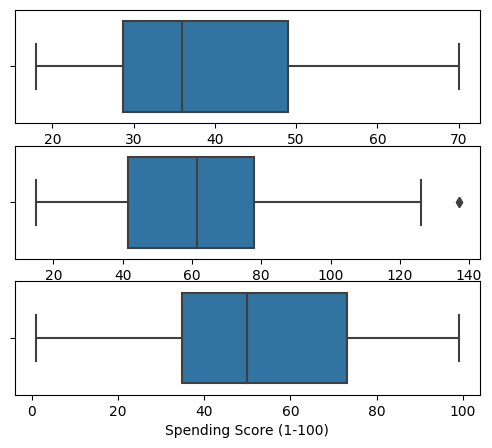

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
fig,(ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(6,5))
sns.boxplot(data=df, x= 'Age', ax= ax1)
sns.boxplot(data=df, x='Annual Income (k$)', ax= ax2)
sns.boxplot(data=df, x='Spending Score (1-100)', ax=ax3)

<ipython-input-7-29923ba59938>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Age'])


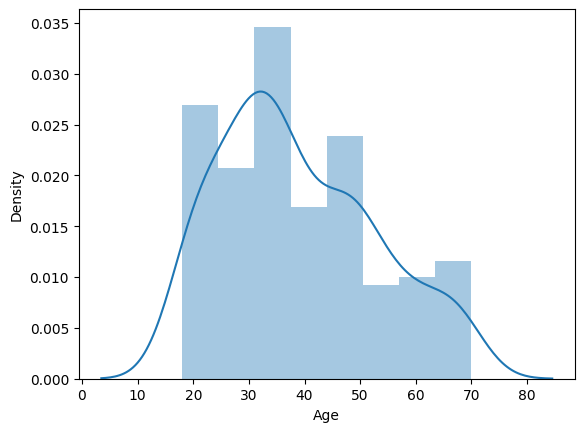

In [7]:
sns.distplot(df['Age'])
plt.show()

<ipython-input-8-8c1a4a363c32>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Annual Income (k$)'])


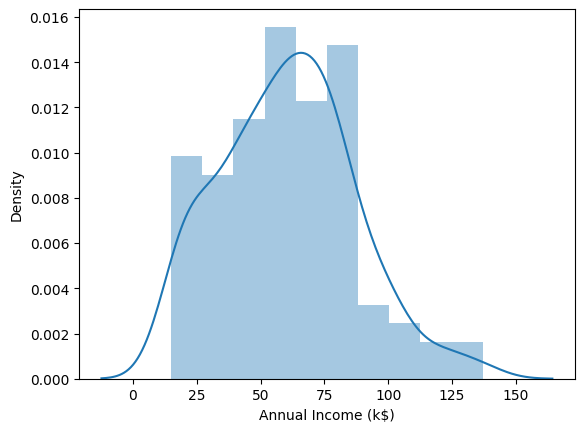

In [8]:
sns.distplot(df['Annual Income (k$)'])
plt.show()

<ipython-input-9-d36c0a696dcb>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Spending Score (1-100)'])


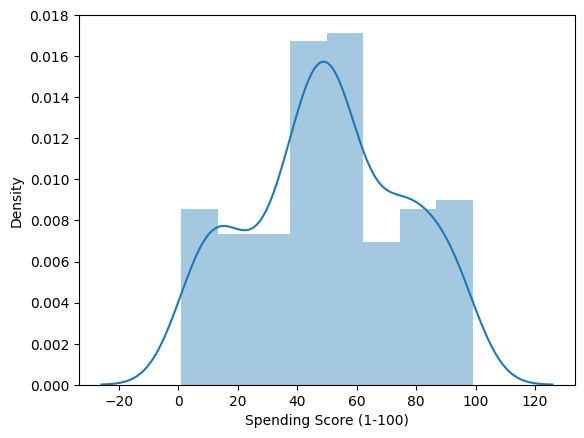

In [9]:
sns.distplot(df['Spending Score (1-100)'])
plt.show()

In [10]:
df['Gender'].value_counts() # 1 Female

Female    112
Male       88
Name: Gender, dtype: int64

In [11]:
df.isna().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

<ipython-input-12-7009e6d029c3>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr())


<Axes: >

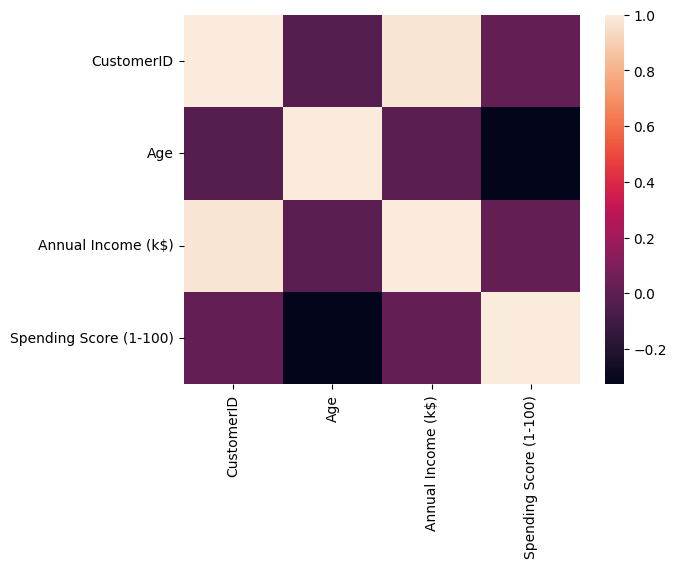

In [12]:
sns.heatmap(df.corr())
#거의 변수끼리 큰 상관관계가 없음을 볼 수 있다.

## 라벨 인코더 및 수치 스케일링

In [13]:
df.columns

Index(['CustomerID', 'Gender', 'Age', 'Annual Income (k$)',
       'Spending Score (1-100)'],
      dtype='object')

In [14]:
df['Gender'] = df['Gender'].replace({"Male": 0, "Female" : 1})

In [15]:
scale_target = df.iloc[:,2:].select_dtypes('int64').columns.tolist()

In [16]:
from sklearn.preprocessing import StandardScaler
ss= StandardScaler()
df[scale_target] =  ss.fit_transform(df[scale_target])

In [17]:
df[scale_target].agg({"mean", "std"}).round(2)

,Age,Annual Income (k$),Spending Score (1-100)
std,1.0,1.0,1.0
mean,-0.0,-0.0,-0.0


### K-means clustering
- k개의 평균을 가진 클러스터를 나눈다는 의미
- clustering 기법들 중에 가장 간편하고 빠른 방법
- K-means clustering의 최적의 K값 결정
- Elbow method: K값의 변화에 따른 Sum Sqaured Error의 추이 확인
- Silhouette methodLink: K값 변화에 따른 실루엣 스코어 확인.

> Silhouette method
- 실루엣 점수는 클러스터 내의 거리와 클러스터 간 거리를 동시에 고려하여 산출되며, 높을수록 좋습니다.
- 대개의 경우에 실루엣 점수가 두번째로 높은 것을 선택하는 것이 경험적으로 좋은 결과를 가져온다고 알려져 있습니다.
- k가 증가하면서 sse가 점점 줄어들다가 어느 지점부터는 감소폭이 작아짐. 감소폭이 확연히 줄어드는 그 지점이 elbow.
- SSE란 각 값들과 중심(centroid) 차이의 거리(error)를 제곱한 다음 모두 합한 값

##### elbow plot으로 k 설정

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

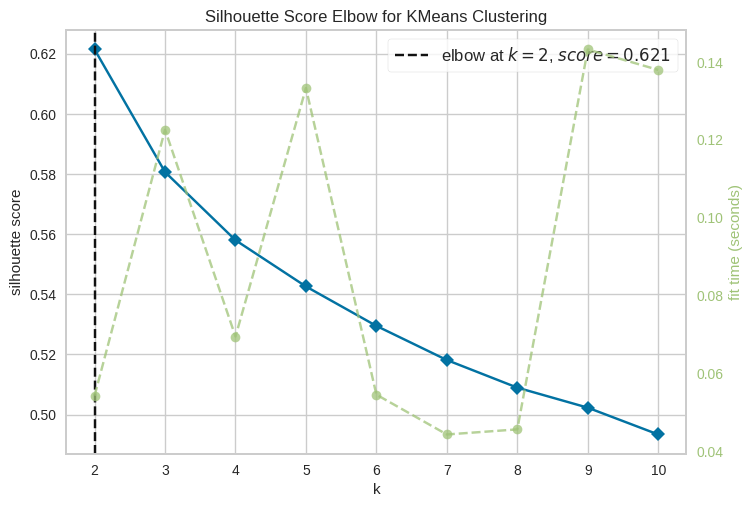

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [18]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer


km=KMeans()
Elbow = KElbowVisualizer(estimator=km, k=10, metric='silhouette') #keibow
Elbow.fit(df)
Elbow.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

{1: 667299.2799999999, 2: 167169.74460261408, 3: 74551.65674924126, 4: 42139.6088535326, 5: 27161.28769082666, 6: 18982.24861559975, 7: 14060.352823760857, 8: 10864.20721756788, 9: 8694.006324763293, 10: 7206.527070988517}


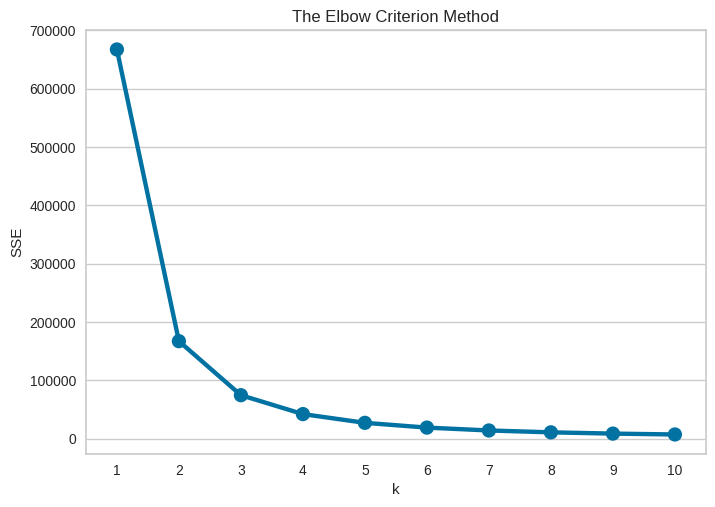

In [19]:
sse = {}
for k in range(1,11):
  km = KMeans(n_clusters = k, random_state=1)
  km.fit(df)
  sse[k] = km.inertia_
print(sse)

sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.title("The Elbow Criterion Method")
plt.xlabel("k")
plt.ylabel("SSE")
plt.show()
#elbow 그림을 살펴봤을 때에는 확연히 줄어드는 기울기를 보아 3 또는4가 적당해 보임

##### k-means-clustering 시각화

In [20]:
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(df)
df.head()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),cluster
0,1,0,-1.424569,-1.738999,-0.434801,2
1,2,0,-1.281035,-1.738999,1.195704,2
2,3,1,-1.352802,-1.700830,-1.715913,2
3,4,1,-1.137502,-1.700830,1.040418,2
4,5,1,-0.563369,-1.662660,-0.395980,2


In [21]:
df.cluster.value_counts()

2    67
1    67
0    66
Name: cluster, dtype: int64

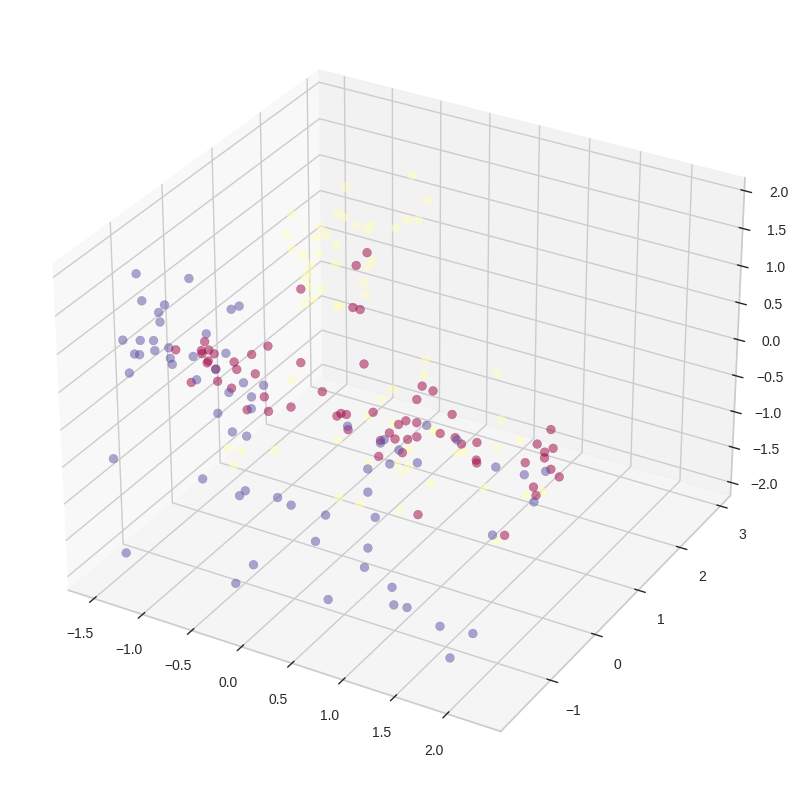

In [22]:
x = df['Age']
y = df['Annual Income (k$)']
z = df['Spending Score (1-100)']


fig = plt.figure(figsize=(12,10))
ax=plt.subplot(111, projection='3d')
ax.scatter(x,y,z , c= df['cluster'], marker='o', cmap='Spectral',alpha=0.5, s=40) #alpha=-0.5 색상 투명도

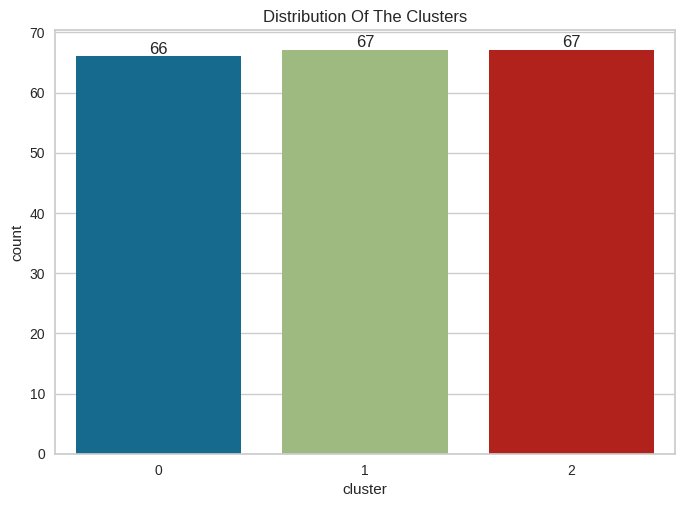

In [23]:
ax = sns.countplot(x=df["cluster"])
ax.bar_label(ax.containers[0])
ax.set_title("Distribution Of The Clusters")
plt.show()

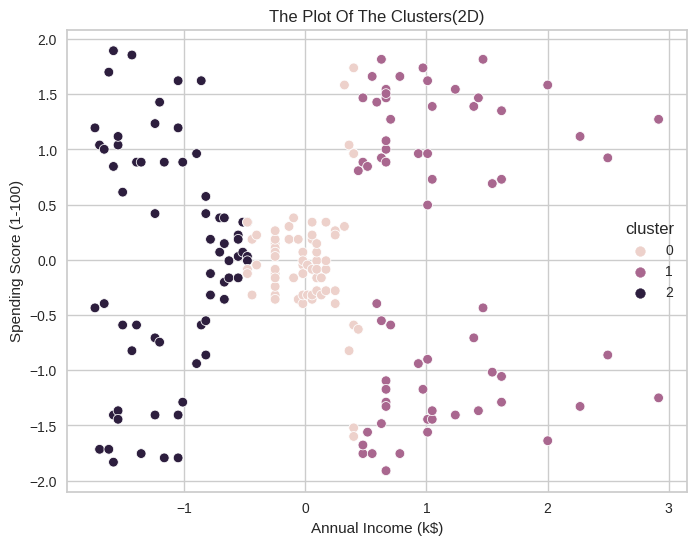

In [24]:
# 2 dimension

plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='Annual Income (k$)', y='Spending Score (1-100)', hue='cluster')
plt.title('The Plot Of The Clusters(2D)')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


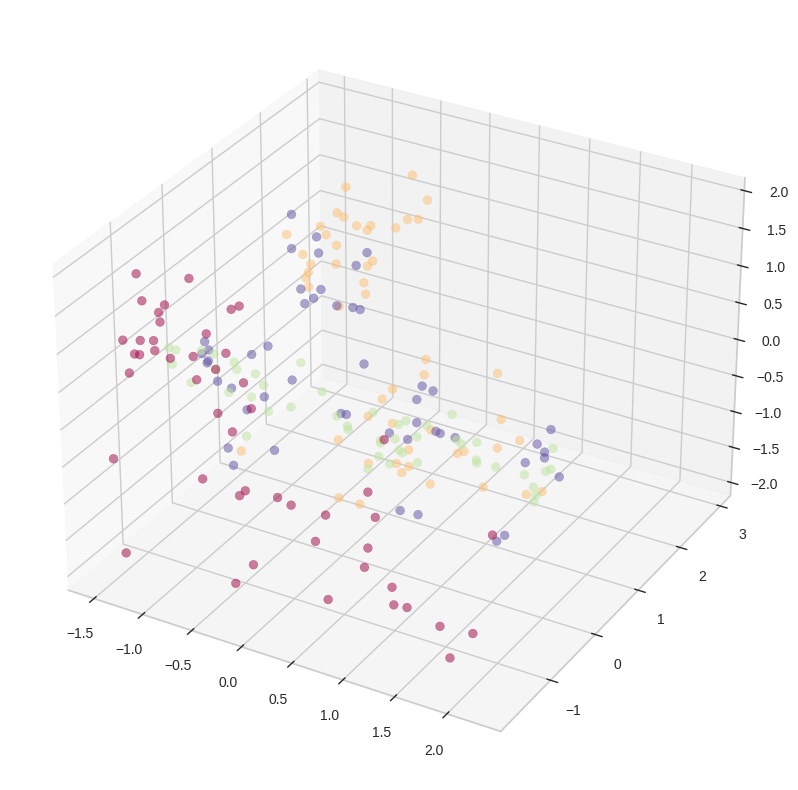

In [25]:
kmeans = KMeans(n_clusters=4, random_state=42)
df['cluster'] = kmeans.fit_predict(df)
x = df['Age']
y = df['Annual Income (k$)']
z = df['Spending Score (1-100)']

df.cluster.value_counts()

fig = plt.figure(figsize=(12,10))
ax=plt.subplot(111, projection='3d')
ax.scatter(x,y,z , c= df['cluster'], marker='o', cmap='Spectral',alpha=0.5,  s=40)
#alpha=-0.5 색상 투명도 #s 점의 크기

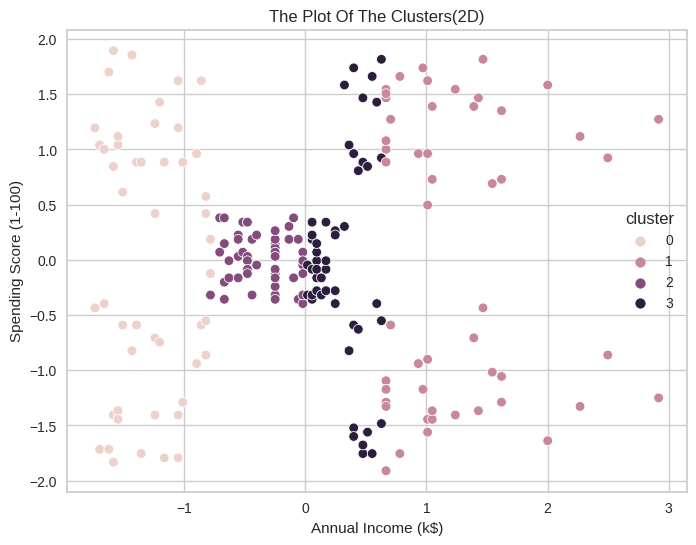

In [26]:
# 2 dimension

plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='Annual Income (k$)', y='Spending Score (1-100)', hue='cluster')
plt.title('The Plot Of The Clusters(2D)')
plt.show()

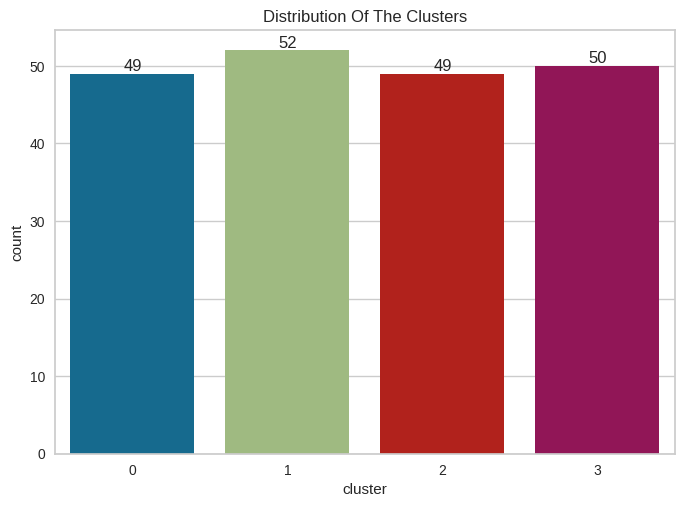

In [27]:
ax = sns.countplot(x=df["cluster"])
ax.bar_label(ax.containers[0])
ax.set_title("Distribution Of The Clusters")
plt.show()

In [28]:
kmeans.labels_

#df 테이블에 Cluster라는 컬럼을 새로 만들어서 label을 여기에 할당하는 코드
# cluster_labels = kmeans.labels_
# df= df.assign(cluster = cluster_labels)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1], dtype=int32)

In [35]:
df_agg = df.groupby('cluster').agg({"Age" :  'mean', 'Annual Income (k$)': 'mean', \
                                    'Spending Score (1-100)': ['mean','median']})
df_agg

Age Annual Income (k$) Spending Score (1-100)          
             mean               mean                   mean    median
cluster                                                              
0       -0.249938          -1.275513              -0.022025 -0.124229
1       -0.118967           1.249961              -0.000299  0.031057
2        0.395962          -0.361005               0.008081  0.031057
3       -0.019377           0.303829               0.013976 -0.065997

Text(0.5, 1.0, 'Age, Annual Income, Spending Score by Clusters')

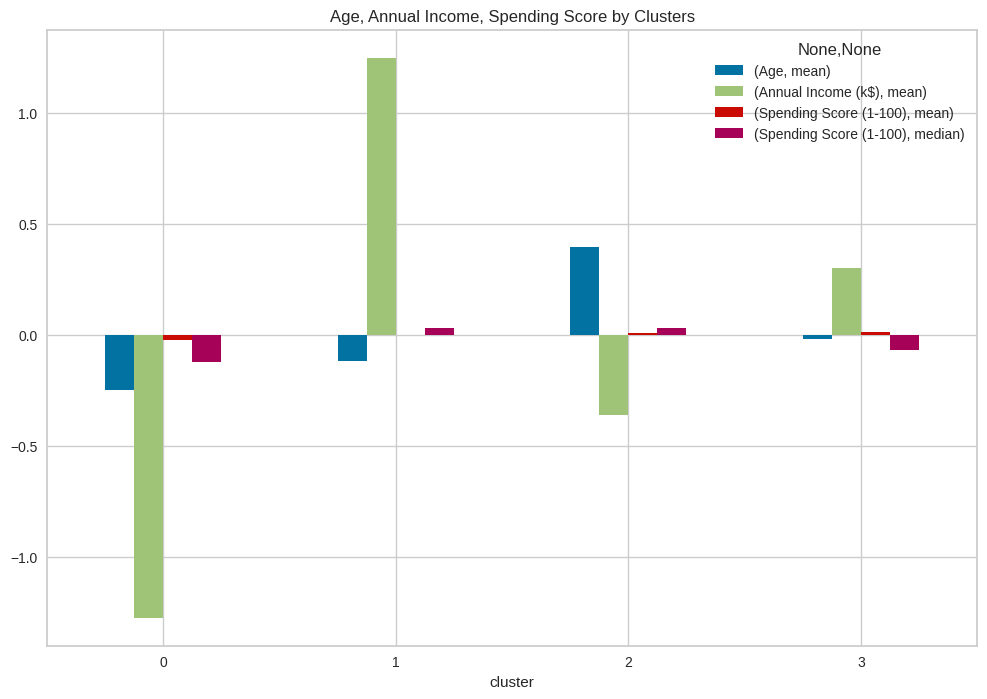

In [36]:
df_agg.plot.bar(figsize=(12,8), rot=0)
plt.title("Age, Annual Income, Spending Score by Clusters")